# Wright-Fisher model of mutation and random genetic drift

A Wright-Fisher model has a fixed population size N and discrete non-overlapping generations. Each generation, each individual has a random number of offspring whose mean is proportional to the individual's fitness. Each generation, mutation may occur.

Setup

In [59]:
import numpy as np
import statistics as stat
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from itertools import *
try:
    import itertools.izip as zip
except ImportError:
    import itertools

In [3]:
def flatten(listOfLists):
    "Flatten one level of nesting"
    return chain.from_iterable(listOfLists)


Make population dynamic model

Basic parameters

In [4]:
pop_size = 1000
seq_length = 1
alphabet = ['0','1']
base_haplotype = "0"


Setup a population of sequences

Store this as a lightweight Dictionary that maps a string to a count. All the sequences together will have count N.


In [5]:
pop = {}
pop["0"] = 100
pop["1"] = 900

Add mutation

Mutations occur each generation in each individual in every basepair.



In [6]:
mutation_rate = 0.0005 # per gen per individual per site

Walk through population and mutate basepairs.
Use Poisson splitting to speed this up (you may be familiar with Poisson splitting from its use in the Gillespie algorithm).

In naive scenario A: take each element and check for each if event occurs. For example, 100 elements, each with 1% chance. This requires 100 random numbers.
In Poisson splitting scenario B: Draw a Poisson random number for the number of events that occur and distribute them randomly. In the above example, this will most likely involve 1 random number draw to see how many events and then a few more draws to see which elements are hit.
First off, we need to get random number of total mutations


In [30]:
def get_mutation_count():
    mean = mutation_rate * pop_size * seq_length
    return np.random.poisson(mean)
#Here we use Numpy's Poisson random number.

get_mutation_count()

9

In [98]:
pop.keys()

dict_keys(['0', '1'])

In [99]:

[x/float(pop_size) for x in pop.values()]


[0.1, 0.9]

In [27]:
def get_random_haplotype():
    haplotypes = list(pop.keys())
    frequencies = [x/float(pop_size) for x in pop.values()]
    total = sum(frequencies)
    frequencies = [x / total for x in frequencies]
    return np.random.choice(haplotypes, p=frequencies)

get_random_haplotype()

'1'

Here, we take a supplied haplotype and mutate a site at random.


In [26]:
def get_mutant(haplotype):
    site = np.random.randint(seq_length)
    possible_mutations = list(alphabet)
    possible_mutations.remove(haplotype[site])
    mutation = np.random.choice(possible_mutations)
    new_haplotype = haplotype[:site] + mutation + haplotype[site+1:]
    return new_haplotype

get_mutant("0")


'1'

Putting things together, in a single mutation event, we grab a random haplotype from the population, mutate it, decrement its count, and then check if the mutant already exists in the population. If it does, increment this mutant haplotype; if it doesn't create a new haplotype of count 1.


In [28]:
def mutation_event():
    haplotype = get_random_haplotype()
    if pop[haplotype] > 1:
        pop[haplotype] -= 1
        new_haplotype = get_mutant(haplotype)
        if new_haplotype in pop:
            pop[new_haplotype] += 1
        else:
            pop[new_haplotype] = 1
mutation_event()
pop

{'0': 99, '1': 101}

To create all the mutations that occur in a single generation, we draw the total count of mutations and then iteratively add mutation events.


In [31]:
def mutation_step():
    mutation_count = get_mutation_count()
    for i in range(mutation_count):
        mutation_event()
mutation_step()
pop

{'0': 99, '1': 101}

## Genetic drift and selection

Selection and fitness are influenced by the game and payoff matrix

In [16]:
awm = x = 0.1
amw = y =  0.1
s=0


In [14]:
def get_fitness(awm, amw, s, frequencies):
    payoff=[[1, 1+awm], [1+s+amw, 1+s]]
    x = frequencies
    f = np.dot(payoff,x)
    fitness = {'0':f[0], '1':f[1]}
    return fitness

In [15]:
pop = {'0':500, '1':500}
haplotypes = list(pop.keys())
frequencies = [pop[haplotype]/float(pop_size) for haplotype in haplotypes]


In [17]:
def get_offspring_counts(s,x,y):
    haplotypes = list(pop.keys())
    frequencies = [pop[haplotype]/float(pop_size) for haplotype in haplotypes]
    fitness = get_fitness(x,y,s,frequencies)
    fitnesses = [fitness[haplotype] for haplotype in haplotypes]
    weights = [x * y for x,y in zip(frequencies, fitnesses)]
    total = sum(weights)
    weights = [x / total for x in weights]
    #print(weights)
    return list(np.random.multinomial(pop_size, weights))
#Here we use Numpy's multinomial random sample.

get_offspring_counts(s,x,y)


[488, 512]


We then need to assign this new list of haplotype counts to the pop dictionary. To save memory and computation, if a haplotype goes to 0, we remove it entirely from the pop dictionary.


In [18]:
def offspring_step(s,x,y):
    haplotypes = list(pop.keys())
    counts = get_offspring_counts(s,x,y)
    for (haplotype, count) in zip(haplotypes, counts):
        if (count > 0):
            pop[haplotype] = count
        else:
            pop[haplotype] = 0
offspring_step(s,x,y)
pop

{'0': 517, '1': 483}

Combine and iterate

Each generation is simply a mutation step where a random number of mutations are thrown down, and an offspring step where haplotype counts are updated.


In [19]:
def time_step(s,x,y):
    mutation_step()
    offspring_step(s,x,y)

Can iterate this over a number of generations.


Record

We want to keep a record of past population frequencies to understand dynamics through time. At each step in the simulation, we append to a history object.


In [33]:
pop0 = {'0':500,'1':500}
history = []
generations = 1000


def simulate(s,x,y):
    history = []
    clone_pop = dict(pop)
    history.append(clone_pop)
    for i in range(generations):
        time_step(s,x,y)
        clone_pop = dict(pop)
        history.append(clone_pop)
    return(history)



List of game options

In [22]:
amw_list = [random.uniform(-0.3, 0.3) for i in range(100)]
awm_list = [random.uniform(-0.3, 0.3) for i in range(100)]

merged_list = [(amw_list[i], awm_list[i]) for i in range(0, len(amw_list))]
fixed_list = [(0.2, 0.2) for i in range(0,len(amw_list))]
coords = merged_list
x = [i[0] for i in coords]
y = [i[1] for i in coords]


# Masking, maintenance and mimicry



The following expressions are for non-zero μ

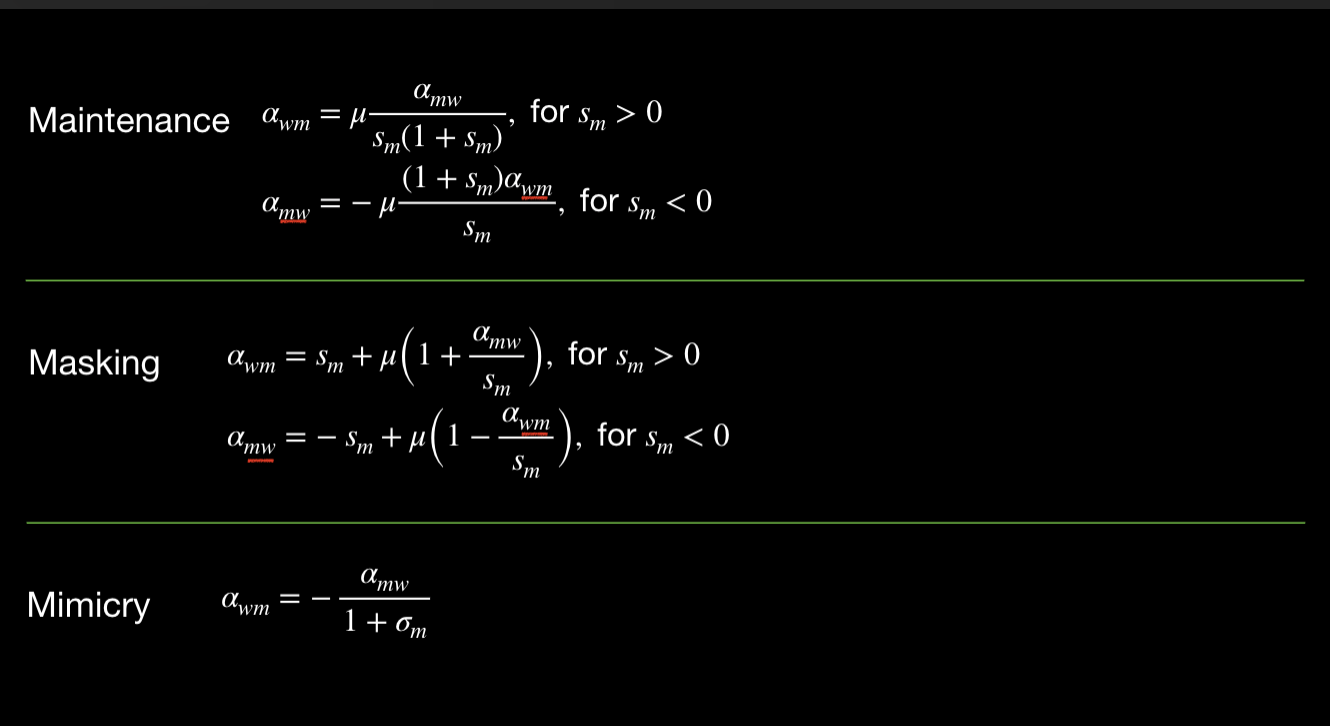

### Functions for maintenance, masking and mimicry

Small μ → 0

In [9]:
def maintain_0(awm, s):
    amw = awm = 0
    return(amw)

def mask_0(awm, s):
    amw = awm -2*s
    return(amw)

def mimic_0(awm, s):
    amw = -s/(1+s)
    return(amw)



μ^2 → 0

In [34]:
def maintain_1(amw, s, mu):
    awm = mu*amw/(s*(1+s))
    return(awm)

def mask_1(amw, s, mu):
    awm = 2*s + amw
    return(awm)

def mimic_1(amw, s, mu):
    awm = -s/(1+s) + (-s + amw)*mu/(s*(1+s))
    return(awm)



###Maintenance simulations
Maintenance is when the outcome (mode) of the simulation is kept the same

Original simulation, s=0.05, μ=0.005

In [ ]:
from numpy.lib.function_base import kaiser
pop = {'0':500,'1':500}

#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []
s=0.1
sm=0
mutation_rate = 0.01
generations = gens = 2000
reps = 20

awm_vals = np.linspace(-0.15,0.15,6)
for m in [0.002,0.004,0.006,0.008,0.01]:
    for jj in awm_vals :
        history = []
        history1 = []
        print(jj)
        for i in range(1,reps+1):
            pop = {'0':500,'1':500}
            k = 0
            j = 0
            mutation_rate = m
            a = simulate(s,j,k)
            history1.append(stat.mode([ii['0'] for ii in a[(gens-101):(gens-1)]]))
            #history.append(a)
        #print(s, j ,k )
        #histories.append(history)
        histories1.append({'mu':m, 'a_wm':jj, 'mode':stat.mode(history1)})

#modes = bstat.mode(outcomes, axis=0)



-0.15
-0.09
-0.03
0.03
0.09
0.15
-0.15
-0.09
-0.03
0.03
0.09
0.15
-0.15
-0.09
-0.03
0.03
0.09
0.15


In [178]:
np.savetxt('reps20_gens2000_s0.1_.out', histories1)

[{'mu': 0.002, 'a_wm': -0.15, 'mode': 80},
 {'mu': 0.002, 'a_wm': -0.09, 'mode': 93},
 {'mu': 0.002, 'a_wm': -0.03, 'mode': 77},
 {'mu': 0.002, 'a_wm': 0.03, 'mode': 88},
 {'mu': 0.002, 'a_wm': 0.09, 'mode': 110},
 {'mu': 0.002, 'a_wm': 0.15, 'mode': 75},
 {'mu': 0.004, 'a_wm': -0.15, 'mode': 87},
 {'mu': 0.004, 'a_wm': -0.09, 'mode': 84},
 {'mu': 0.004, 'a_wm': -0.03, 'mode': 87},
 {'mu': 0.004, 'a_wm': 0.03, 'mode': 89},
 {'mu': 0.004, 'a_wm': 0.09, 'mode': 94}]

(0.0, 1000.0)

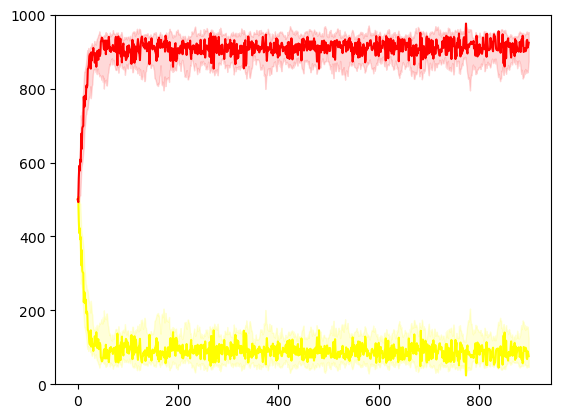

In [116]:
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]

for t in range(0,gens):
    vals0 = []
    vals1=[]
    for si in range(0,reps):
        sli = histories[2][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))


len(mode0)
ax = sns.lineplot(x=[i for i in range(0,gens)], y=mode0, color='yellow')
ax.fill_between(
    [i for i in range(0,gens)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,gens)], y=mode1, color='r')
ax1.fill_between(
    [i for i in range(0,gens)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))


Maintenance

μ^2 →0 , interactions are non-zero

In [10]:
from numpy.lib.function_base import kaiser
pop = {'0':500,'1':500}

#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []
s=0.1
sm=0
mutation_rate = mu = 0.01
generations = gens = 10
reps = 25

for jj in awm_vals :
    outcome = []
    history = []
    history1 = []
    print(jj)
    for i in range(1,reps+1):
        pop = {'0':500,'1':500}
        k = awm = jj
        j = maintain_1(amw=k, s=s, mu=mu)
        a = simulate(s,j,k)
        history1.append(stat.mode([ii['0'] for ii in a[(gens-101):(gens-1)]]))
        history.append(a)
        #print(s, j ,k )
    outcomes.append(outcome)
    histories.append(history)
    histories1.append(history1)

#modes = stat.mode(outcomes, axis=0)

#np.savetxt('s0.05a120.14_a210.16_games50_.out', (np.array(x), np.array(y), means))

-0.15


NameError: name 'simulate' is not defined

(0.0, 1000.0)

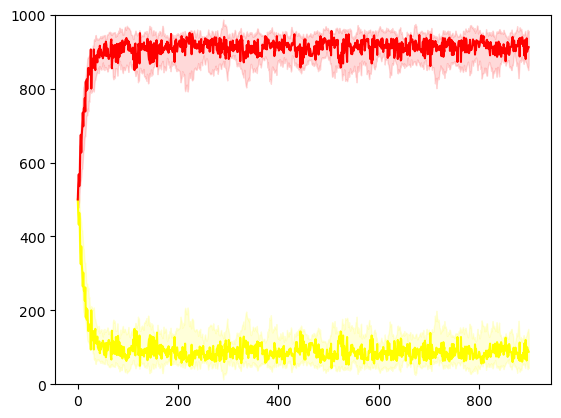

In [172]:
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]

for t in range(0,gens):
    vals0 = []
    vals1=[]
    for si in range(0,reps):
        sli = histories[4][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))


len(mode0)
ax = sns.lineplot(x=[i for i in range(0,gens)], y=mode0, color='yellow')
ax.fill_between(
    [i for i in range(0,gens)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,gens)], y=mode1, color='r')
ax1.fill_between(
    [i for i in range(0,gens)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))

Masking

In masking the presence of interactions removes selective differences

In [119]:
pop = {'0':500,'1':500}

#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []
s=0.1
sm=0
mutation_rate = mu = 0.001
generations = gens = 900
reps = 25

for jj in awm_vals:
    outcome = []
    history = []
    history1=[]
    print(jj)
    for i in range(1,reps+1):
        pop = {'0':500,'1':500}
        k = awm = jj
        j = mask_0(awm=k, s=s)
        a = simulate(s,k,j)
        outcome.append(a[gens-1]['0'])
        history1.append([ii['0'] for ii in a])
        history.append(a)
        #print(s, j ,k )
    outcomes.append(outcome)
    histories1.append(flatten(history1))
    histories.append(history)


#np.savetxt('s0.05a120.14_a210.16_games50_.out', (np.array(x), np.array(y), means))

-0.15
-0.09
-0.03
0.03
0.09
0.15


In [120]:
mode_hist = [stat.mode(i) for i in histories1]
mode_hist

[1000, 998, 996, 994, 27, 500]

(0.0, 1000.0)

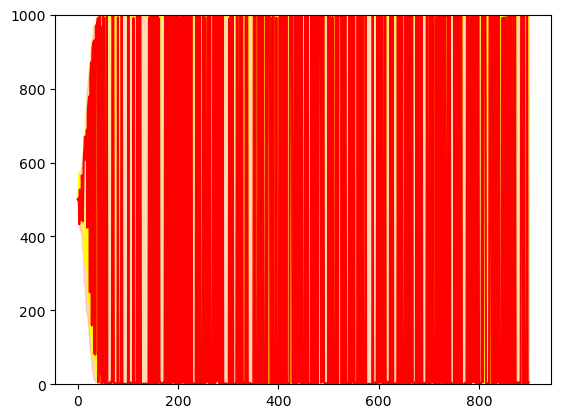

In [121]:
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
gens = 900
for t in range(0,gens):
    vals0 = []
    vals1=[]
    for si in range(0,reps):
        sli = histories[1][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))


len(mode0)
ax = sns.lineplot(x=[i for i in range(0,gens)], y=mode0, color='yellow')
ax.fill_between(
    [i for i in range(0,gens)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,gens)], y=mode1, color='r')
ax1.fill_between(
    [i for i in range(0,gens)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))


First order μ

In [122]:
pop = {'0':500,'1':500}

#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []

s=0.1
sm=0
mutation_rate = mu =0.01
generations = gens = 900
reps = 25

for jj in awm_vals:
    outcome = []
    history = []
    history1 = []
    print(jj)
    for i in range(1,reps+1):
        pop = {'0':500,'1':500}
        amw = jj
        awm = mask_1(amw=amw, s=s,mu=mu)
        a = simulate(s,awm,amw)
        history1.append([ii['0'] for ii in a])
        history.append(a)
        #print(s, j ,k )
    outcomes.append(outcome)
    histories1.append(flatten(history1))
    histories.append(history)



-0.15
-0.09
-0.03
0.03
0.09
0.15


In [123]:
mode_hist = [stat.mode(i) for i in histories1]
mode_hist

[500, 511, 498, 489, 513, 502]

(0.0, 1000.0)

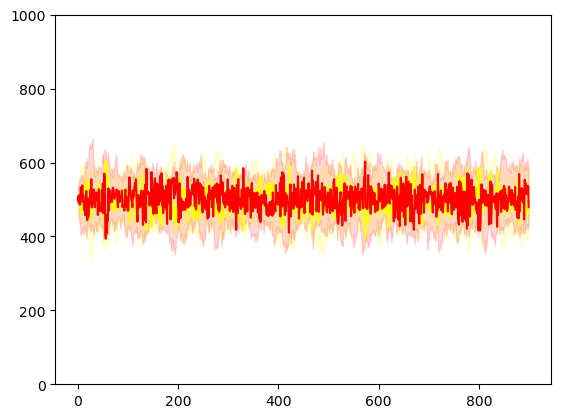

In [124]:
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
gens = 900
for t in range(0,gens):
    vals0 = []
    vals1=[]
    for si in range(0,reps):
        sli = histories[3][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))


len(mode0)
ax = sns.lineplot(x=[i for i in range(0,gens)], y=mode0, color='yellow')
ax.fill_between(
    [i for i in range(0,gens)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,gens)], y=mode1, color='r')
ax1.fill_between(
    [i for i in range(0,gens)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))

Mimicry

In the absence of cell-intrinsic selection, interactions alone can cause selective pressures

In [157]:
pop = {'0':500,'1':500}

#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []
s=0       # Intrinsic selection difference
sm=0.1    # Selection to mimic
mutation_rate = mu = 0.01
generations = gens = 900
reps = 25

for jj in awm_vals:
    outcome = []
    history = []
    history1=[]
    print(jj)
    for i in range(1,reps+1):
        pop = {'0':500,'1':500}
        amw = jj
        awm = mimic_0(amw, s=sm)
        a = simulate(s,awm,amw)
        history1.append([ii['0'] for ii in a])
        history.append(a)
        #print(s, j ,k )
    outcomes.append(outcome)
    histories1.append(flatten(history1))
    histories.append(history)


-0.15
-0.09
-0.03
0.03
0.09
0.15


In [138]:
mode_hist = [stat.mode(i) for i in histories1]
mode_hist

[942, 102, 100, 94, 89, 77]

(0.0, 1000.0)

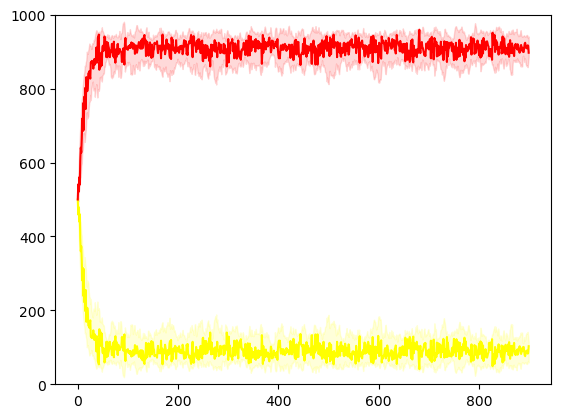

In [162]:
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
gens = 900
for t in range(0,gens):
    vals0 = []
    vals1=[]
    for si in range(0,reps):
        sli = histories[4][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))


len(mode0)
ax = sns.lineplot(x=[i for i in range(0,gens)], y=mode0, color='yellow')
ax.fill_between(
    [i for i in range(0,gens)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,gens)], y=mode1, color='r')
ax1.fill_between(
    [i for i in range(0,gens)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))

Mimicry 1st order

In [155]:
pop = {'0':500,'1':500}

#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []
s=0         # Intrinsic selection difference
sm=0.1      # Selection to mimic
mutation_rate = mu =0.01
generations = gens = 900
reps = 100

for jj in awm_vals:
    outcome = []
    history = []
    history1 =[]
    print(jj)
    for i in range(1,reps+1):
        pop = {'0':500,'1':500}
        amw = jj
        awm = mimic_1(amw, s=sm, mu=mu)
        a = simulate(s,awm,amw)
        history1.append([ii['0'] for ii in a])
        history.append(a)
        #print(s, j ,k )
    outcomes.append(outcome)      
    histories1.append(flatten(history1))
    histories.append(history)

-0.15
-0.09
-0.03
0.03
0.09
0.15


In [144]:
mode_hist = [stat.mode(i) for i in histories1]
mode_hist

[941, 91, 88, 84, 85, 88]

(0.0, 1000.0)

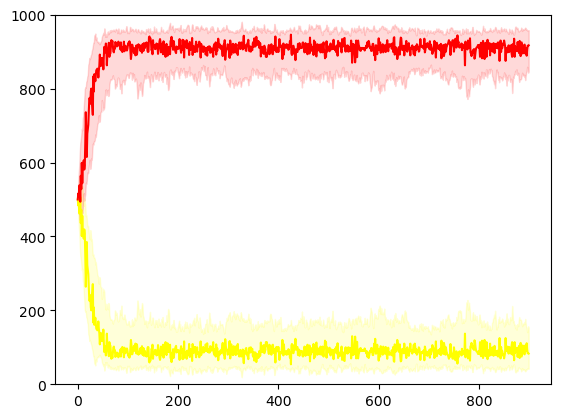

In [156]:
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
gens = 900
for t in range(0,gens):
    vals0 = []
    vals1=[]
    for si in range(0,reps):
        sli = histories[2][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))


len(mode0)
ax = sns.lineplot(x=[i for i in range(0,gens)], y=mode0, color='yellow')
ax.fill_between(
    [i for i in range(0,gens)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,gens)], y=mode1, color='r')
ax1.fill_between(
    [i for i in range(0,gens)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))

Summary plotting for manuscript

1. Plot amw as function of awm (x3 cases)
2. Plot different lines for s 
3. Plot different lines for mu


In [7]:
awm_vals = np.linspace(-0.15,0.15,10)
s_vals = np.linspace(0,1,10)
mu_vals = np.linspace(0.001, 0.1, 10)

In [84]:
mask_df = pd.DataFrame({'awm':awm_vals,
                        'amw_s005_mu005':mask_1(awm_vals, 0.05, 0.005),
                        'amw_s01_mu005':mask_1(awm_vals, 0.1, 0.005),
                        'amw_s015_mu005':mask_1(awm_vals, 0.15, 0.005),
                        'amw_s005_mu05':mask_1(awm_vals, 0.05, 0.05),
                        'amw_s01_mu05':mask_1(awm_vals, 0.1, 0.05),
                        'amw_s015_mu05':mask_1(awm_vals, 0.15, 0.05),
                        'amw_s005_mu5':mask_1(awm_vals, 0.05, 0.5),
                        'amw_s01_mu5':mask_1(awm_vals, 0.1, 0.5),
                        'amw_s015_mu5':mask_1(awm_vals, 0.15, 0.5)
                       })

<AxesSubplot:xlabel='awm', ylabel='amw_s005_mu05'>

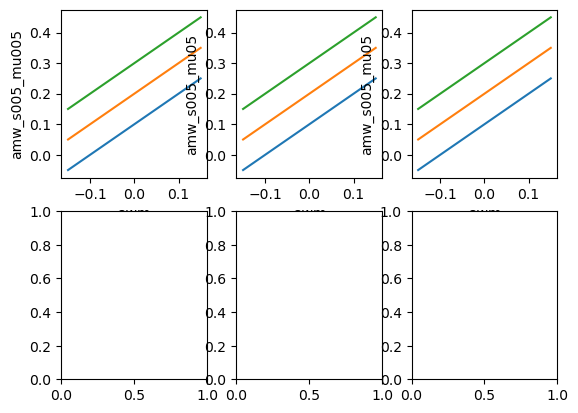

In [85]:
fig, axes = plt.subplots(2, 3)

sns.lineplot(data =mask_df,x='awm',y='amw_s005_mu005', ax=axes[0,0])
sns.lineplot(data =mask_df,x='awm',y='amw_s01_mu005', ax=axes[0,0])
sns.lineplot(data =mask_df,x='awm',y='amw_s015_mu005', ax=axes[0,0])

sns.lineplot(data =mask_df,x='awm',y='amw_s005_mu05', ax=axes[0,1])
sns.lineplot(data =mask_df,x='awm',y='amw_s01_mu05', ax=axes[0,1])
sns.lineplot(data =mask_df,x='awm',y='amw_s015_mu05', ax=axes[0,1])

sns.lineplot(data =mask_df,x='awm',y='amw_s005_mu05', ax=axes[0,2])
sns.lineplot(data =mask_df,x='awm',y='amw_s01_mu05', ax=axes[0,2])
sns.lineplot(data =mask_df,x='awm',y='amw_s015_mu05', ax=axes[0,2])


In [87]:
mimic_df = pd.DataFrame({'awm':awm_vals,
                        'amw_s005_mu005':mimic_1(awm_vals, 0.05, 0.005),
                        'amw_s01_mu005':mimic_1(awm_vals, 0.1, 0.005),
                        'amw_s015_mu005':mimic_1(awm_vals, 0.15, 0.005),
                        'amw_s005_mu05':mimic_1(awm_vals, 0.05, 0.05),
                        'amw_s01_mu05':mimic_1(awm_vals, 0.1, 0.05),
                        'amw_s015_mu05':mimic_1(awm_vals, 0.15, 0.05),
                        'amw_s005_mu5':mimic_1(awm_vals, 0.05, 0.5),
                        'amw_s01_mu5':mimic_1(awm_vals, 0.1, 0.5),
                        'amw_s015_mu5':mimic_1(awm_vals, 0.15, 0.5)
                       })

<AxesSubplot:xlabel='awm', ylabel='amw_s015_mu005'>

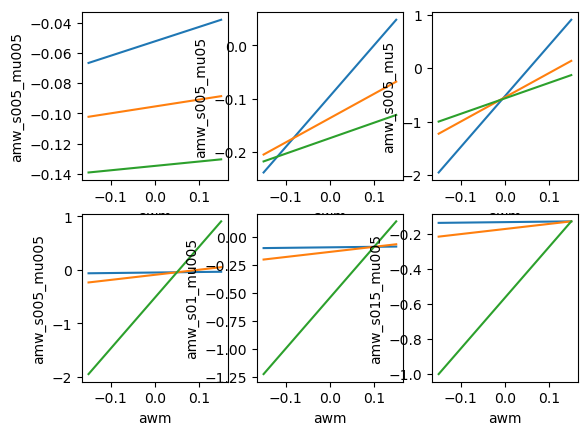

In [92]:
fig, axes = plt.subplots(2, 3)

sns.lineplot(data =mimic_df,x='awm',y='amw_s005_mu005', ax=axes[0,0])
sns.lineplot(data =mimic_df,x='awm',y='amw_s01_mu005', ax=axes[0,0])
sns.lineplot(data =mimic_df,x='awm',y='amw_s015_mu005', ax=axes[0,0])

sns.lineplot(data =mimic_df,x='awm',y='amw_s005_mu05', ax=axes[0,1])
sns.lineplot(data =mimic_df,x='awm',y='amw_s01_mu05', ax=axes[0,1])
sns.lineplot(data =mimic_df,x='awm',y='amw_s015_mu05', ax=axes[0,1])

sns.lineplot(data =mimic_df,x='awm',y='amw_s005_mu5', ax=axes[0,2])
sns.lineplot(data =mimic_df,x='awm',y='amw_s01_mu5', ax=axes[0,2])
sns.lineplot(data =mimic_df,x='awm',y='amw_s015_mu5', ax=axes[0,2])

sns.lineplot(data =mimic_df,x='awm',y='amw_s005_mu005', ax=axes[1,0])
sns.lineplot(data =mimic_df,x='awm',y='amw_s005_mu05', ax=axes[1,0])
sns.lineplot(data =mimic_df,x='awm',y='amw_s005_mu5', ax=axes[1,0])

sns.lineplot(data =mimic_df,x='awm',y='amw_s01_mu005', ax=axes[1,1])
sns.lineplot(data =mimic_df,x='awm',y='amw_s01_mu05', ax=axes[1,1])
sns.lineplot(data =mimic_df,x='awm',y='amw_s01_mu5', ax=axes[1,1])


sns.lineplot(data =mimic_df,x='awm',y='amw_s015_mu005', ax=axes[1,2])
sns.lineplot(data =mimic_df,x='awm',y='amw_s015_mu05', ax=axes[1,2])
sns.lineplot(data =mimic_df,x='awm',y='amw_s015_mu5', ax=axes[1,2])


In [57]:
amw_maintain_s01 = maintain_1(awm_vals, 0.1, 0.05)
amw_maintain_s015 = maintain_1(awm_vals, 0.15, 0.05)
amw_maintain_s02 = maintain_1(awm_vals, 0.2, 0.05)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/pyt

<AxesSubplot:>

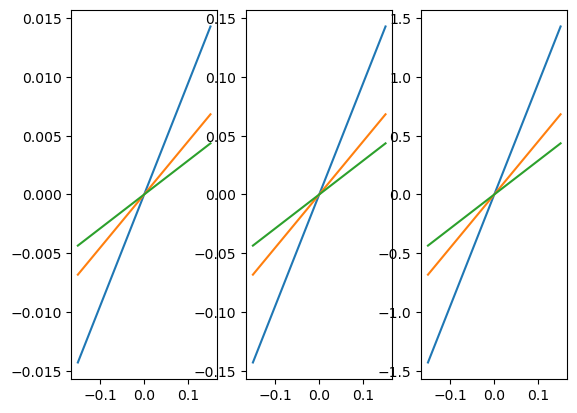

In [69]:
fig, axes = plt.subplots(1, 3)


sns.lineplot(awm_vals, maintain_1(awm_vals, 0.05, 0.005), ax=axes[0])
sns.lineplot(awm_vals, maintain_1(awm_vals, 0.1, 0.005), ax=axes[0])
sns.lineplot(awm_vals, maintain_1(awm_vals, 0.15, 0.005), ax=axes[0])

sns.lineplot(awm_vals, maintain_1(awm_vals, 0.05, 0.05), ax=axes[1])
sns.lineplot(awm_vals, maintain_1(awm_vals, 0.1, 0.05), ax=axes[1])
sns.lineplot(awm_vals, maintain_1(awm_vals, 0.15, 0.05), ax=axes[1])

sns.lineplot(awm_vals, maintain_1(awm_vals, 0.05, 0.5), ax=axes[2])
sns.lineplot(awm_vals, maintain_1(awm_vals, 0.1, 0.5), ax=axes[2])
sns.lineplot(awm_vals, maintain_1(awm_vals, 0.15, 0.5), ax=axes[2])

Error in masking etc?

In [ ]:
#Masking 
for alph in []:
    for s in []:
        for mu in []:
            result = simulate(alph, s, mu)
            mode = mode(result)
            var = variance(result)
            mode_th = theory_mode(alph, s, mu)
            error = result - mode_th
            df.append(alph, mu,s,mode, var, error)

In [2]:
#Mimic
for alph in []:
    for s in []:
        for mu in []:
            result = simulate(alph, s, mu)
            mode = mode(result)
            var = variance(result)
            mode_th = theory_mode(alph, s, mu)
            error = result - mode_th
            df.append(alph, mu,s,mode, var, error)


NameError: name 'to_plot' is not defined

In [ ]:
#Maintain 
for alph in []:
    for s in []:
        for mu in []:
            result = simulate(alph, s, mu)
            mode = mode(result)
            var = variance(result)
            mode_th = theory_mode(alph, s, mu)
            error = result - mode_th
            df.append(alph, mu,s,mode, var, error)

<AxesSubplot:>

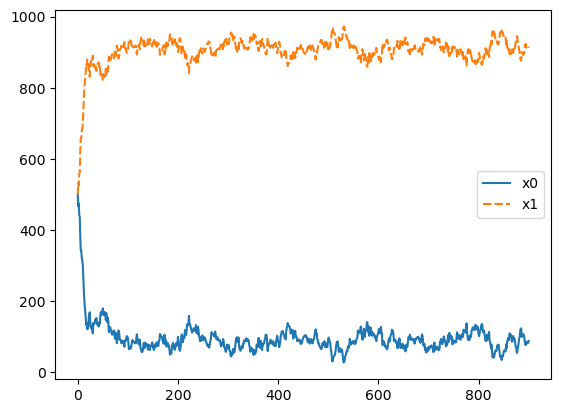

In [131]:
j, k
x0 = [i['0'] for i in a]
x1 = [i['1'] for i in a]
df = pd.DataFrame({'x0':x0, 'x1':x1})
sns.lineplot(data=df[['x0', 'x1']], sort=False)


In [ ]:
from itertools import chain


def flatten(listOfLists):
    "Flatten one level of nesting"
    return chain.from_iterable(listOfLists)

list(flatten(outcomes))

In [ ]:
out = list(flatten(outcomes))
graph = sns.scatterplot(x=np.linspace(1,len(out), len(out)), y=out, linewidth=0)
graph.axhline(0, c="black")
graph.axvline(0,  c="black")
graph.axhline(-s, c="black", linestyle='--')
graph.axvline(s,  c="black", linestyle='--')
graph.legend('')
N= sum(pop.values())
mu= mutation_rate
print('s'+str(s)+'N'+str(N)+'mu'+str(mu))


In [ ]:
len(out)

In [ ]:
graph =sns.histplot(x=[i/1000 for i in out], kde=True)
#graph.axhline(0, c="black")
plt.xlim(0,1)
#graph.axhline(-s, c="black", linestyle='--')
#graph.axvline(s,  c="black", linestyle='--')
graph.legend('')
N= sum(pop.values())
mu= mutation_rate
print('s'+str(s)+'N'+str(N)+'mu'+str(mu))




plt.show()

In [ ]:
outcomes

### Plot diversity

Here, we use matplotlib for all Python plotting.
